In [1]:
import cv2
import os
import numpy as np
from tensorflow import keras
from keras import layers
from keras import models
from tensorflow.keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import random,shutil
from keras.models import Sequential
from keras.layers import Dropout,Conv2D,Flatten,Dense, MaxPooling2D, BatchNormalization

# Reading all images from dataset and labeling them

In [2]:
Datadirectory = '../dataset/train'
Classes = ['closed', 'open']
training_data = []

In [3]:
def create_training_data():
    for category in Classes:
        path = os.path.join(Datadirectory, category)
        class_num = Classes.index(category)
        for img in os.listdir(path):
            try :
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                blackToRGB = cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)
                #new_array = cv2.resize(backtorgb, (img_size,img_size))
                training_data.append([blackToRGB, class_num])
            except Exception as e:
                print(e)

In [4]:
create_training_data()

In [5]:
print(len(training_data))

3242


# Image processing

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
#test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
train_dir = '../dataset/train'
img_size = 224
batch_size = 20
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_size, img_size),
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

Found 2594 images belonging to 2 classes.
Found 648 images belonging to 2 classes.


In [19]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 224, 224, 3)
labels batch shape: (20,)


# model

In [20]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(img_size, img_size, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

## compile model

In [21]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

#     optimizer = Adam(0.0001)
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# new_model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer = "adam", metrics = ["accuracy"])

In [22]:
    #train_generator.samples // batch_size
      #validation_steps = validation_generator.samples // batch_size,

history = model.fit(
    train_generator,
    steps_per_epoch=30,
    epochs=15, #30
    validation_data = validation_generator,
    validation_steps = 15) 

Epoch 1/15
30/30 [==============================] - 39s 1s/step - loss: 0.6769 - acc: 0.5917 - val_loss: 0.6986 - val_acc: 0.4567
Epoch 2/15
30/30 [==============================] - 37s 1s/step - loss: 0.5971 - acc: 0.7017 - val_loss: 0.5956 - val_acc: 0.9033
Epoch 3/15
30/30 [==============================] - 37s 1s/step - loss: 0.5181 - acc: 0.7683 - val_loss: 0.5458 - val_acc: 0.8867
Epoch 4/15
30/30 [==============================] - 42s 1s/step - loss: 0.4247 - acc: 0.8233 - val_loss: 0.4473 - val_acc: 0.8800
Epoch 5/15
30/30 [==============================] - 35s 1s/step - loss: 0.3862 - acc: 0.8583 - val_loss: 0.3607 - val_acc: 0.9333
Epoch 6/15
30/30 [==============================] - 35s 1s/step - loss: 0.3393 - acc: 0.8817 - val_loss: 0.3442 - val_acc: 0.9267
Epoch 7/15
30/30 [==============================] - 46s 2s/step - loss: 0.2811 - acc: 0.8900 - val_loss: 0.2371 - val_acc: 0.9500
Epoch 8/15
30/30 [==============================] - 36s 1s/step - loss: 0.2239 - acc: 0.92

In [23]:
model.save('models/cnnBasic.h5', overwrite=True)

## plot acc

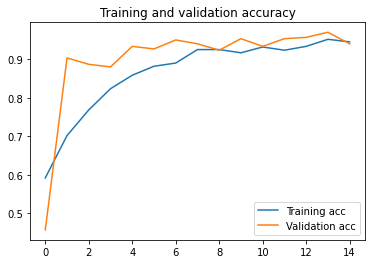

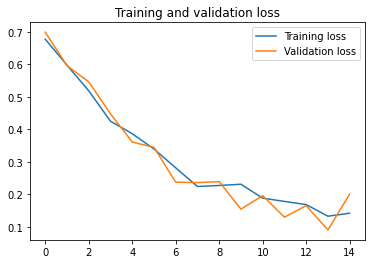

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# make confusion matrix

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15):   
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
            horizontalalignment="center",
            color="white" if cm[i, j] > threshold else "black",
            size=text_size)